# Data Enrichment & Predictive Maintenance



## 1. Load & Preprocess the Sensor **Data**

We use the **NASA C-MAPSS dataset**, which contains sensor readings from engines under various operating conditions. Our goal is to preprocess the data and prepare it for **feature engineering using Generative AI**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

# Load dataset
file_path = "https://raw.githubusercontent.com/arijoury/statsmodels/main/train_FD001.txt"  # Adjust path if needed
column_names = ["unit", "cycle", "op_setting_1", "op_setting_2", "op_setting_3",
                "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5",
                "sensor_6", "sensor_7", "sensor_8", "sensor_9", "sensor_10",
                "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15",
                "sensor_16", "sensor_17", "sensor_18", "sensor_19", "sensor_20", "sensor_21"]

df = pd.read_csv(file_path, sep=' ', header=None, names=column_names, engine='python')
df = df.dropna(axis=1, how='all')  # Remove empty columns (due to formatting)

In [ ]:
# Identify zero-variance sensors
zero_variance_sensors = [col for col in df.columns if "sensor" in col and np.var(df[col]) == 0]

# Drop zero-variance sensors
df = df.drop(columns=zero_variance_sensors)

print(f"Dropped sensors with zero variance: {zero_variance_sensors}")

Dropped sensors with zero variance: []


In [ ]:
zero_var_per_unit = []

for col in sensor_cols:
    per_unit_var = df.groupby("unit")[col].var().fillna(0)
    if all(per_unit_var == 0):
        zero_var_per_unit.append(col)

df = df.drop(columns=zero_var_per_unit)
print(f"Dropped sensors with zero variance within each unit: {zero_var_per_unit}")

Dropped sensors with zero variance within each unit: ['sensor_3', 'sensor_8', 'sensor_14']


In [ ]:
# Compute Remaining Useful Life (RUL)
rul_df = df.groupby("unit")["cycle"].max().reset_index()
rul_df.columns = ["unit", "max_cycle"]
df = df.merge(rul_df, on="unit")
df["RUL"] = df["max_cycle"] - df["cycle"]
df.drop(columns=["max_cycle"], inplace=True)

# Normalize sensor data
scaler = MinMaxScaler()
sensor_cols = [col for col in df.columns if "sensor" in col]
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

df.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_4,sensor_5,sensor_6,sensor_7,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_15,sensor_18,sensor_19,RUL
0,-0.0007,-0.0004,100.0,518.67,641.82,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,0.0010
1,0.0019,-0.0003,100.0,518.67,642.15,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,0.0009
2,-0.0043,0.0003,100.0,518.67,642.35,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,0.0002
3,0.0007,0.0000,100.0,518.67,642.35,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,0.0005
4,-0.0019,-0.0002,100.0,518.67,642.37,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,0.0007


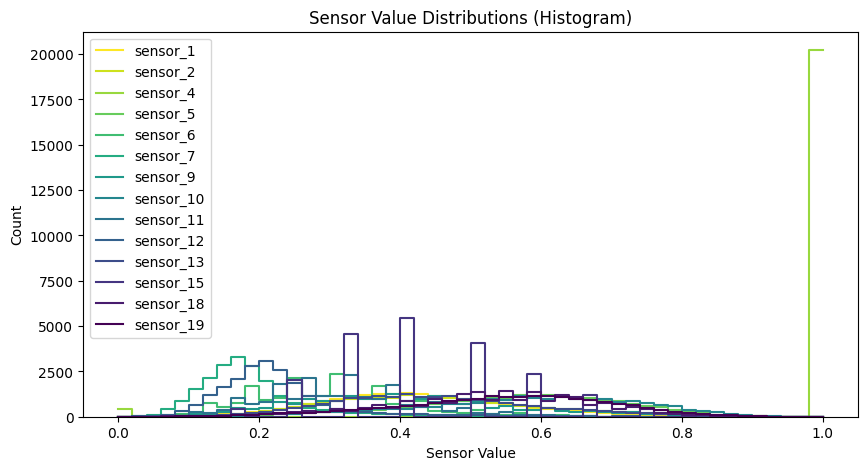

In [ ]:
plt.figure(figsize=(10, 5))

sensor_cols = [col for col in df.columns if "sensor" in col]  # Get all sensor columns
colors = plt.cm.viridis_r(np.linspace(0, 1, len(sensor_cols)))  # Generate colors

for sensor, color in zip(sensor_cols, colors):
    sns.histplot(df[sensor], bins=50, label=sensor, color=color, element="step", fill=False, linewidth=1.5)

plt.xlabel("Sensor Value")
plt.ylabel("Count")
plt.title("Sensor Value Distributions (Histogram)")
plt.legend()
plt.show()


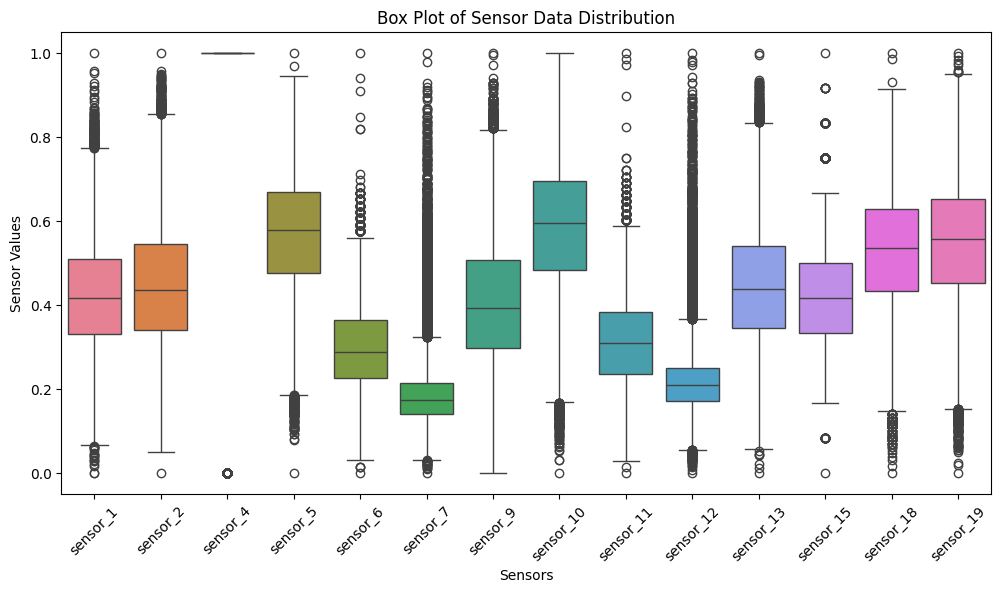

In [ ]:
# Create a box plot for all sensor readings
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[sensor_cols])
plt.xticks(rotation=45)
plt.xlabel("Sensors")
plt.ylabel("Sensor Values")
plt.title("Box Plot of Sensor Data Distribution")
plt.show()

In [ ]:
# prompt: Can you train a model to predict RUL?

# Prepare data for training
X = df[['cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + sensor_cols]
y = df['RUL']

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define a simple neural network model
class RULPredictor(nn.Module):
    def __init__(self, input_size):
        super(RULPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model
input_size = X_train.shape[1]
model = RULPredictor(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1))
    print(f'Test Loss: {test_loss.item():.4f}')

# You can further analyze the results, calculate metrics like RMSE, and visualize the predictions vs actual RUL values.


Epoch [10/100], Loss: 9.1066
Epoch [20/100], Loss: 0.0087
Epoch [30/100], Loss: 1.3141
Epoch [40/100], Loss: 1.9782
Epoch [50/100], Loss: 1.0444
Epoch [60/100], Loss: 0.0955
Epoch [70/100], Loss: 0.0415
Epoch [80/100], Loss: 0.0478
Epoch [90/100], Loss: 0.0003
Epoch [100/100], Loss: 0.0067
Test Loss: 0.0046


Dropped sensors with zero variance: ['sensor_16', 'sensor_17']
Dropped sensors with zero variance within each unit: ['sensor_3', 'sensor_8', 'sensor_14']
Epoch [10/100], Loss: 1.3828
Epoch [20/100], Loss: 0.1824
Epoch [30/100], Loss: 0.8931
Epoch [40/100], Loss: 0.9201
Epoch [50/100], Loss: 0.3523
Epoch [60/100], Loss: 0.0091
Epoch [70/100], Loss: 0.0322
Epoch [80/100], Loss: 0.0130
Epoch [90/100], Loss: 0.0018
Epoch [100/100], Loss: 0.0021
Test Loss: 0.0009


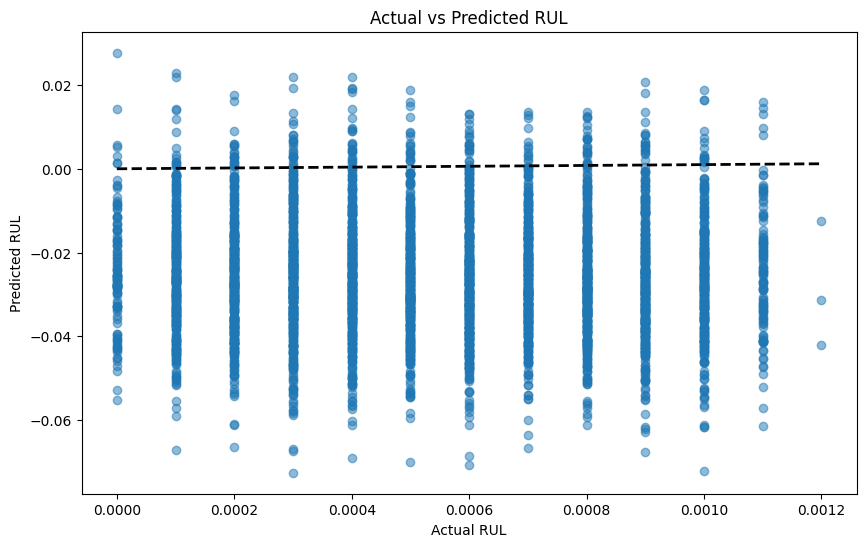

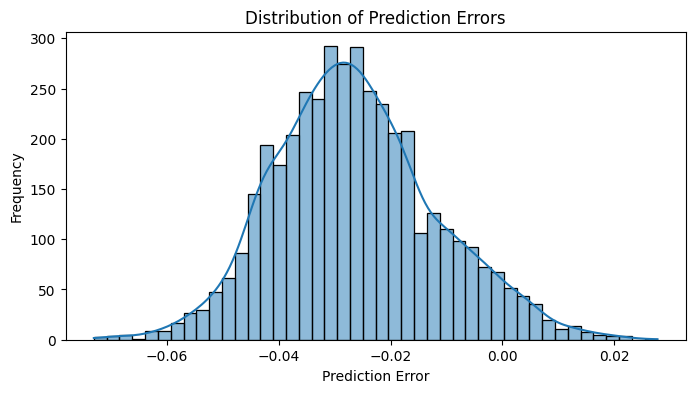

In [ ]:
# prompt: Test this model on https://raw.githubusercontent.com/arijoury/statsmodels/main/test_FD001.txt and make one or multiple visualizations of the model's performance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns


# Load dataset
file_path = "https://raw.githubusercontent.com/arijoury/statsmodels/main/train_FD001.txt"  # Adjust path if needed
column_names = ["unit", "cycle", "op_setting_1", "op_setting_2", "op_setting_3",
                "sensor_1", "sensor_2", "sensor_3", "sensor_4", "sensor_5",
                "sensor_6", "sensor_7", "sensor_8", "sensor_9", "sensor_10",
                "sensor_11", "sensor_12", "sensor_13", "sensor_14", "sensor_15",
                "sensor_16", "sensor_17", "sensor_18", "sensor_19", "sensor_20", "sensor_21"]

df = pd.read_csv(file_path, sep=' ', header=None, names=column_names, engine='python')
df = df.dropna(axis=1, how='all')  # Remove empty columns (due to formatting)

# Identify zero-variance sensors
zero_variance_sensors = [col for col in df.columns if "sensor" in col and np.var(df[col]) == 0]

# Drop zero-variance sensors
df = df.drop(columns=zero_variance_sensors)

print(f"Dropped sensors with zero variance: {zero_variance_sensors}")
sensor_cols = [col for col in df.columns if "sensor" in col]
zero_var_per_unit = []

for col in sensor_cols:
    per_unit_var = df.groupby("unit")[col].var().fillna(0)
    if all(per_unit_var == 0):
        zero_var_per_unit.append(col)

df = df.drop(columns=zero_var_per_unit)
print(f"Dropped sensors with zero variance within each unit: {zero_var_per_unit}")
# Compute Remaining Useful Life (RUL)
rul_df = df.groupby("unit")["cycle"].max().reset_index()
rul_df.columns = ["unit", "max_cycle"]
df = df.merge(rul_df, on="unit")
df["RUL"] = df["max_cycle"] - df["cycle"]
df.drop(columns=["max_cycle"], inplace=True)

# Normalize sensor data
scaler = MinMaxScaler()
sensor_cols = [col for col in df.columns if "sensor" in col]
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

# Prepare data for training
X = df[['cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + sensor_cols]
y = df['RUL']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Define a simple neural network model
class RULPredictor(nn.Module):
    def __init__(self, input_size):
        super(RULPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Create the model
input_size = X_train.shape[1]
model = RULPredictor(input_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.unsqueeze(1))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1))
    print(f'Test Loss: {test_loss.item():.4f}')

# Visualize the model's performance
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred.numpy(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.show()

# Calculate and visualize the distribution of errors
errors = y_pred.numpy().flatten() - y_test
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.show()


## 2. LLM-Based Feature Engineering with ChatGPT
We use **ChatGPT (LLM)** to **suggest new sensor features** based on existing data.
This can help uncover **hidden relationships** and improve model accuracy.

In [1]:
# get OpenAI keys
from google.colab import drive
drive.mount('/content/drive')

with open('/content/drive/MyDrive/Wangari/Product/openai_key.txt', 'r') as f:
    api_key = f.read().strip()

Mounted at /content/drive


In [ ]:
from openai import OpenAI

client = OpenAI(
    # This is the default and can be omitted
    api_key=api_key,
)

In [ ]:
# Define a function to ask ChatGPT for feature engineering suggestions
def generate_features(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}]
    )
    return response.choices[0].message.content

In [ ]:
# Example: Ask ChatGPT for new features based on engine sensor data
prompt = "Suggest three new features based on the engine sensor data in the NASA C-MAPSS dataset for predictive maintenance. Please refer to each sensor by the name it has in the dataset, e.g., sensor_2, sensor_3, etc."
new_features = generate_features(prompt)
print(new_features)

When analyzing the NASA C-MAPSS dataset for predictive maintenance, creating new features derived from existing sensor data can improve the accuracy and robustness of machine learning models predicting remaining useful life (RUL) or potential failures. Here are three feature engineering suggestions using the available sensor data:

1. **Sensor Derivatives**:
   - **Feature:** Calculate the rate of change for selected sensors over time, which can help identify trends or emerging issues.
   - **Example Calculation:** For each sensor, calculate the first derivative, i.e., the difference between consecutive readings. For instance, the derivative of `sensor_2` can be expressed as:
     \[
     \text{Derivative\_sensor\_2} = \text{sensor\_2}(t) - \text{sensor\_2}(t-1)
     \]
   - **Rationale:** Sudden changes in sensor readings might indicate anomalies or accelerated degradation, useful for anticipating maintenance needs.

2. **Exponential Moving Average (EMA)**:
   - **Feature:** Compute t

In [ ]:
# prompt: I want to do some feature engineering. Look at the individual columns for each sensor, and create interaction terms between sensors which make sense, to capture complex relationships and dependencies among system components that might not be apparent from individual sensor readings. Add relevant data that you calculate to the existing dataset.

# ... (Your existing code) ...

# Feature Engineering: Interaction Terms and Sensor Combinations

# Example: Create an interaction term between sensor_1 and sensor_2
df['sensor_1_x_sensor_2'] = df['sensor_1'] * df['sensor_2']

# Example: Calculate the ratio of sensor_3 to sensor_4
df['sensor_3_div_sensor_4'] = df['sensor_3'] / (df['sensor_4'] + 1e-6)  # Add small value to prevent division by zero

# Example: Calculate the difference between sensor_5 and sensor_6
df['sensor_5_minus_sensor_6'] = df['sensor_5'] - df['sensor_6']

# You can continue this process for other sensor combinations that might be relevant based on your understanding of the system.

# Example: Consider using polynomial features for non-linear relationships
# from sklearn.preprocessing import PolynomialFeatures
# poly = PolynomialFeatures(degree=2, interaction_only=True)
# sensor_interactions = poly.fit_transform(df[sensor_cols])
# interaction_cols = [f'interaction_{i}' for i in range(sensor_interactions.shape[1])]
# df_interactions = pd.DataFrame(sensor_interactions, columns=interaction_cols)
# df = pd.concat([df, df_interactions], axis=1)


# Update X to include the new features
X = df[['cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] + sensor_cols + ['sensor_1_x_sensor_2', 'sensor_3_div_sensor_4', 'sensor_5_minus_sensor_6']] # Add your newly created features

# Re-split data into training and testing sets with new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# ... (Rest of your code, including model definition, training, and evaluation) ...



## 📌 3. GAN-Based Data Augmentation
**Generative Adversarial Networks (GANs)** can be used to **create synthetic sensor readings**,
which is useful when real-world failure cases are rare.

In [ ]:
# Re-import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Simulate loading a dataset (since execution state was reset)
np.random.seed(42)
df = pd.DataFrame({
    "sensor_10": np.random.normal(loc=0.5, scale=0.1, size=1000)  # Simulated real sensor data
})

# Normalize the real data for GAN training
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

class Generator(nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),  # Increased neurons
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),  # Added extra layer
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, input_dim)
        )

    def forward(self, x):
        return self.model(x)


# Define Discriminator class
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize Generator and Discriminator
input_dim = df_scaled.shape[1]
generator = Generator(input_dim)
discriminator = Discriminator(input_dim)

# Loss function & optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training the GAN
epochs = 500  # Increase for better results
batch_size = 64

for epoch in range(epochs):
    # Train Discriminator
    real_data = torch.tensor(df_scaled.values, dtype=torch.float32)
    fake_data = generator(torch.randn((real_data.shape[0], input_dim)))

    real_labels = torch.ones(real_data.shape[0], 1) * 0.9  # Instead of 1.0
    fake_labels = torch.zeros(fake_data.shape[0], 1) + 0.1  # Instead of 0.0

    for _ in range(3):
        optimizer_D.zero_grad()
        loss_real = criterion(discriminator(real_data), real_labels)
        loss_fake = criterion(discriminator(fake_data.detach()), fake_labels)
        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

    # Train Generator
    optimizer_G.zero_grad()
    fake_data = generator(torch.randn((real_data.shape[0], input_dim)))
    loss_G = criterion(discriminator(fake_data), real_labels)  # Trick discriminator
    loss_G.backward()
    optimizer_G.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss_D: {loss_D.item():.4f} | Loss_G: {loss_G.item():.4f}")

# Generate synthetic sensor data after training
z = torch.randn((1000, input_dim)) * 5 # Generate 1000 synthetic samples
synthetic_data = generator(z).detach().numpy()
synthetic_df = pd.DataFrame(synthetic_data, columns=df.columns)

# Inverse transform the synthetic data to match the original scale
synthetic_df = pd.DataFrame(scaler.inverse_transform(synthetic_df), columns=df.columns)

Epoch 0 | Loss_D: 0.6660 | Loss_G: 0.7006
Epoch 100 | Loss_D: 0.5972 | Loss_G: 0.7664
Epoch 200 | Loss_D: 0.6206 | Loss_G: 0.8212
Epoch 300 | Loss_D: 0.7078 | Loss_G: 0.6811
Epoch 400 | Loss_D: 0.7022 | Loss_G: 0.6902


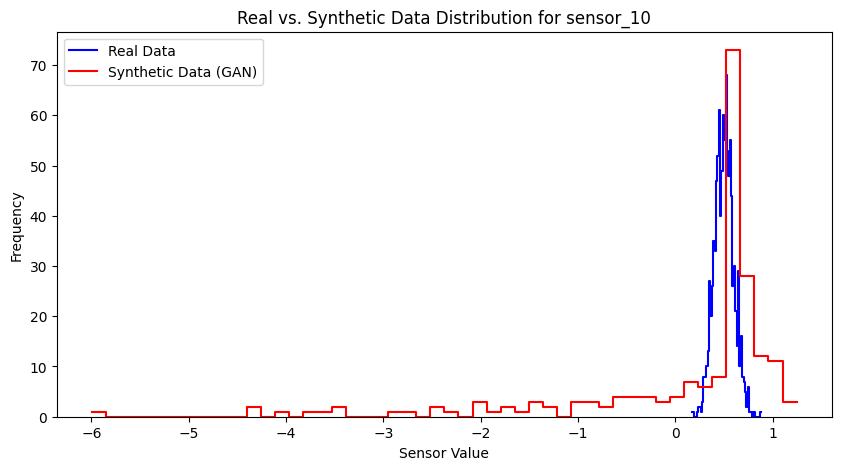

In [ ]:
# Create histogram for real vs. synthetic data
plt.figure(figsize=(10, 5))
sensor_name = "sensor_10"
sns.histplot(df[sensor_name], bins=50, label="Real Data", color="blue", element="step", fill=False, linewidth=1.5)
sns.histplot(synthetic_df[sensor_name].sample(frac=0.2, random_state=42), bins=50, label="Synthetic Data (GAN)", color="red", element="step", fill=False, linewidth=1.5)

plt.xlabel("Sensor Value")
plt.ylabel("Frequency")
plt.title(f"Real vs. Synthetic Data Distribution for {sensor_name}")
plt.legend()
plt.show()

## 📌 4. Variational Autoencoder (VAE) for Latent Feature Extraction
**VAEs (Variational Autoencoders)** are used to **extract hidden latent structures** in sensor data,
which helps detect early signs of equipment failure.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

vae = VAE(input_dim=df.shape[1])
optimizer = optim.Adam(vae.parameters(), lr=0.001)
latent_features = vae.encoder(torch.tensor(df.values, dtype=torch.float32)).detach().numpy()
print(latent_features[:5])

[[ 0.15596426  0.02626107 -0.15505517 -0.44068426  0.07782784 -0.2609221
   0.28576714 -0.26521444  0.34422562 -0.328639    0.19397168 -0.26648545
  -0.31220013 -0.22385494 -0.29915202  0.17419823]
 [ 0.15448096  0.00935166 -0.16513965 -0.41843432  0.09247574 -0.26332095
   0.2942168  -0.2625024   0.3176195  -0.3470695   0.17491035 -0.25190657
  -0.2810339  -0.23326497 -0.28668198  0.18351118]
 [ 0.15709868  0.02969424 -0.15210256 -0.44695643  0.07514963 -0.25952333
   0.28467202 -0.26671076  0.34924144 -0.32501426  0.19870046 -0.2710027
  -0.31816718 -0.22249036 -0.30077678  0.17280896]
 [ 0.16432752  0.050352   -0.13692525 -0.48383132  0.06137789 -0.25291774
   0.28018194 -0.27356896  0.3769823  -0.30412865  0.22665119 -0.29974616
  -0.35220698 -0.21529542 -0.30930817  0.16377749]
 [ 0.15472417  0.00722451 -0.16628692 -0.41532466  0.09506291 -0.2633354
   0.2961886  -0.2621583   0.31310338 -0.3496379   0.17214626 -0.24944209
  -0.27609625 -0.23418294 -0.28492197  0.18533273]]


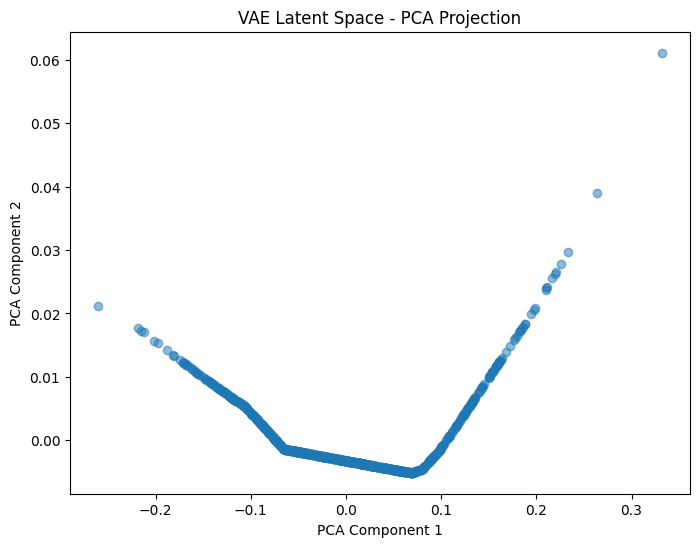

In [ ]:
# PCA visualizaiton
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_features)

plt.figure(figsize=(8,6))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("VAE Latent Space - PCA Projection")
plt.show()

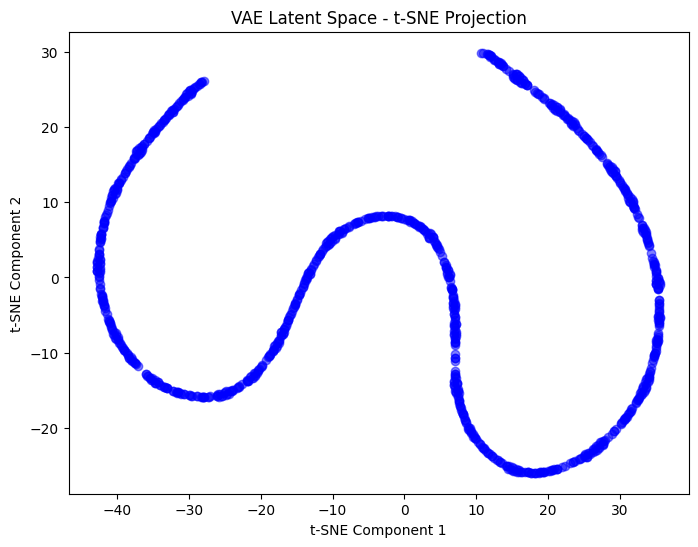

In [ ]:
# t-SNE visualization

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_tsne = tsne.fit_transform(latent_features)

plt.figure(figsize=(8,6))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.5, c="blue")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("VAE Latent Space - t-SNE Projection")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


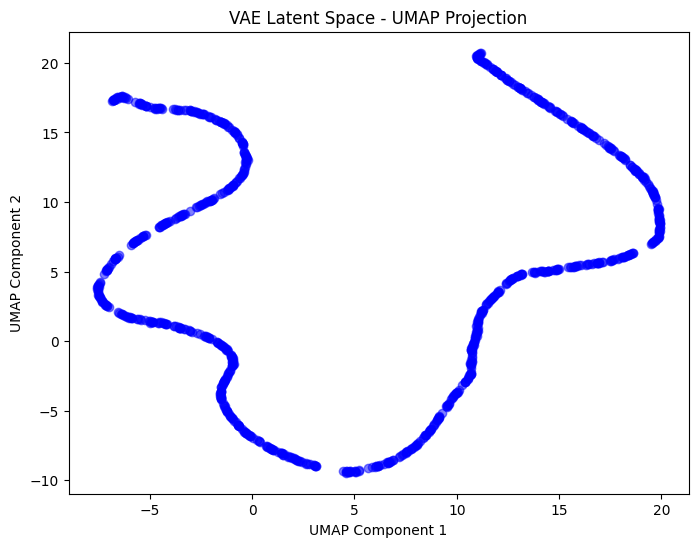

In [ ]:
# UMAP visualization
import umap
import numpy as np
import matplotlib.pyplot as plt

# Assuming `latent_features` is the VAE-encoded latent space representation
latent_umap = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.2, random_state=42).fit_transform(latent_features)

# Plot the UMAP projection
plt.figure(figsize=(8,6))
plt.scatter(latent_umap[:, 0], latent_umap[:, 1], alpha=0.5, c="blue")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("VAE Latent Space - UMAP Projection")
plt.show()

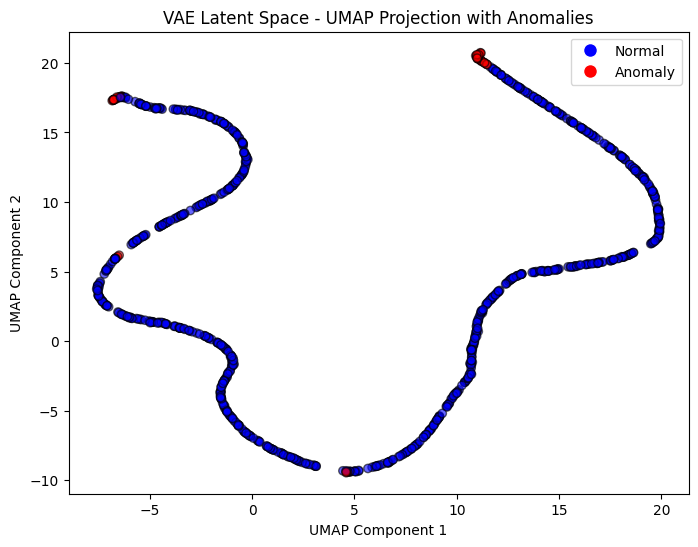

In [ ]:
# Import necessary libraries
from sklearn.ensemble import IsolationForest

# Use Isolation Forest to detect anomalies
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # 5% anomaly threshold
anomaly_scores = iso_forest.fit_predict(latent_umap)  # -1 = anomaly, 1 = normal

# Convert anomalies to color labels
colors = np.where(anomaly_scores == -1, 'red', 'blue')  # Red for anomalies, Blue for normal

# Plot UMAP with anomaly detection
plt.figure(figsize=(8,6))
plt.scatter(latent_umap[:, 0], latent_umap[:, 1], c=colors, alpha=0.6, edgecolors="k")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title("VAE Latent Space - UMAP Projection with Anomalies")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Normal'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Anomaly')],
           loc="upper right")
plt.show()

## 📌 5. Compare Data Enrichment Methods
Here, we compare **the variance of the original, GAN-generated, and VAE-latent datasets** to evaluate the quality of the enrichment.

In [ ]:
#print("Original Data Variance:\n", df.var())
#print("Synthetic GAN Data Variance:\n", synthetic_df.var())
#print("VAE Latent Feature Variance:\n", np.var(latent_features, axis=0))

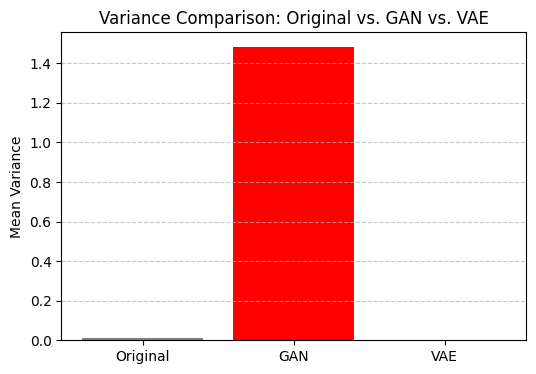

In [ ]:
# Compute variance ratios
original_variance = df.var()
gan_variance = synthetic_df.var()
vae_variance = np.var(latent_features, axis=0)

variance_ratios = {
    "Original": original_variance.mean(),
    "GAN": gan_variance.mean(),
    "VAE": vae_variance.mean()
}

# Plot the variance comparison
plt.figure(figsize=(6, 4))
plt.bar(variance_ratios.keys(), variance_ratios.values(), color=['gray', 'red', 'blue'])

# Formatting
plt.ylabel("Mean Variance")
plt.title("Variance Comparison: Original vs. GAN vs. VAE")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.show()


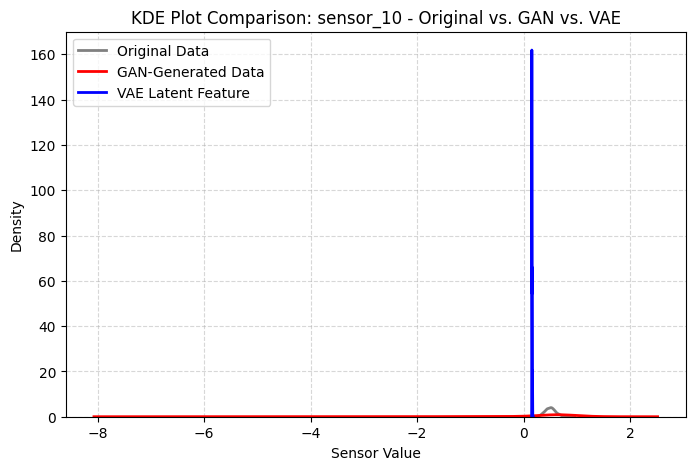

In [ ]:
# Select a common feature to compare across datasets
sensor_feature = "sensor_10"  # Adjust if needed

# Ensure the selected feature exists in both original and synthetic data
if sensor_feature in df.columns and sensor_feature in synthetic_df.columns:
    plt.figure(figsize=(8, 5))

    # KDE plot for original sensor data
    sns.kdeplot(df[sensor_feature], label="Original Data", color="gray", linewidth=2)

    # KDE plot for GAN-generated data
    sns.kdeplot(synthetic_df[sensor_feature], label="GAN-Generated Data", color="red", linewidth=2)

    # KDE plot for VAE latent feature (using first latent dimension as a proxy)
    sns.kdeplot(latent_features[:, 0], label="VAE Latent Feature", color="blue", linewidth=2)

    # Formatting
    plt.xlabel("Sensor Value")
    plt.ylabel("Density")
    plt.title(f"KDE Plot Comparison: {sensor_feature} - Original vs. GAN vs. VAE")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Show the plot
    plt.show()
else:
    print(f"Feature {sensor_feature} not found in both datasets. Please check feature names.")

## 6. Exercise: Generate a Custom GAN or VAE with ChatGPT
- Use **ChatGPT** to generate a custom **GAN or VAE model** for synthetic data.
- Copy-paste the generated code, run it, and **analyze the synthetic output.**


In [ ]:
prompt = "Write a PyTorch GAN for generating synthetic engine sensor data."
gan_code = generate_features(prompt)
print(gan_code)

Creating a Generative Adversarial Network (GAN) in PyTorch for generating synthetic engine sensor data involves several steps. We'll define the generator and discriminator networks, specify the training process, and put it all together in a training loop. Note that the design of the GAN components (e.g., network architecture, hyperparameters) should be tailored to your specific problem domain and data characteristics. Here's a basic implementation to get you started:

```python
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Helper function to initialize weights
def weights_init(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim, data_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128,

✅ **Key Takeaways:**
- **LLMs** automate feature generation for sensor data.
- **GANs** generate realistic synthetic sensor readings.
- **VAEs** uncover hidden failure patterns for predictive maintenance.
- **Comparing data variations** helps assess the effectiveness of each method.
- **Hands-on experience with ChatGPT for AI-driven coding!**